**Table of contents**<a id='toc0_'></a>    
- [Phase II: Clustering within Place Boundaries](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [I: MRE (Minimum Reproducible Example) Data](#toc1_2_)    
    - [County and Place Data](#toc1_2_1_)    
    - [Places 1 Parcel Data](#toc1_2_2_)    
    - [Places 2 Parcel Data](#toc1_2_3_)    
    - [Place 3 Parcel Data](#toc1_2_4_)    
  - [II. Clustering Workflow](#toc1_3_)    
    - [Functions](#toc1_3_1_)    
      - [Step 1: Computing the Distance Matrix for each Region](#toc1_3_1_1_)    
      - [Step 2: Calculating the Density of the Region](#toc1_3_1_2_)    
      - [Step 3: Calculating the Nearest Neighbors Sample Size](#toc1_3_1_3_)    
      - [Step 4: Calculating the Optimal Epsilon](#toc1_3_1_4_)    
      - [Step 5: Clustering the Data](#toc1_3_1_5_)    
      - [Understanding The Variables](#toc1_3_1_6_)    
  - [III. Results](#toc1_4_)    
  - [IV. Cross-Region Clustering](#toc1_5_)    
    - [Step 1: Identify Single Parcels within the Optimal Distance](#toc1_5_1_)    
    - [Step 2: Identify Same-Owner Clusters in different regions within the Optimal Distance](#toc1_5_2_)    
    - [Step 3: Dissolve and Reverse Buffer](#toc1_5_3_)    
  - [V. Cross-Region Clustering Results](#toc1_6_)    
      - [Final Thoughts:](#toc1_6_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Phase II: Clustering within Place Boundaries](#toc0_)
## <a id='toc1_1_'></a>[Introduction](#toc0_)
In this notebook, we are taking our inital clustering workflow and applying a dynamic eplison to the DBSCAN. The notebook applies this idea by utilizing a Place Boundary, which is an unofficial Census boundary representing a local urban area. Within these boundaries, density is calculated to determine an effective Nearest Neibor sample size. The KNN Nearest Neighbor alogrithm is then used to determine the optimal epsilon for the DBSCAN algorithm. The notebook then applies the DBSCAN algorithm to the data and visualizes the results.

In [1]:
from geometry import * # custom module used for MRE data creation and visualization

from shapely.ops import nearest_points
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import uniform_filter1d
import numpy as np
from math import ceil
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPolygon
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')

## <a id='toc1_2_'></a>[I: MRE (Minimum Reproducible Example) Data](#toc0_)
### <a id='toc1_2_1_'></a>[County and Place Data](#toc0_)
Place boundaries represent locally dense urban areas. Boundaries will be used initally as a proxy for regional parcel density where adaptive eps will be calcualted. 

In [2]:
county1 = mPolygon(origin=(0,0), size=(25,25), alpha=0, edgecolor='red', linestyle='--')

In [3]:
place1 = mPolygon(origin=(0, 0), size=(10, 10))
place2 = mPolygon(origin=(0, 12), size=(10, 10))
place3 = mPolygon(origin=(14, 0), size=(10, 25))
places = [place1, place2, place3]

place_data = {
    'Place': ['P1', 'P2', 'P3']
}
place_gdf = GeoDataFrame(place_data, places).build()
place_gdf

,Place,geometry
0,P1,"POLYGON ((0.00000 0.00000, 10.00000 0.00000, 1..."
1,P2,"POLYGON ((0.00000 12.00000, 10.00000 12.00000,..."
2,P3,"POLYGON ((14.00000 0.00000, 24.00000 0.00000, ..."


In [4]:
map = Map()

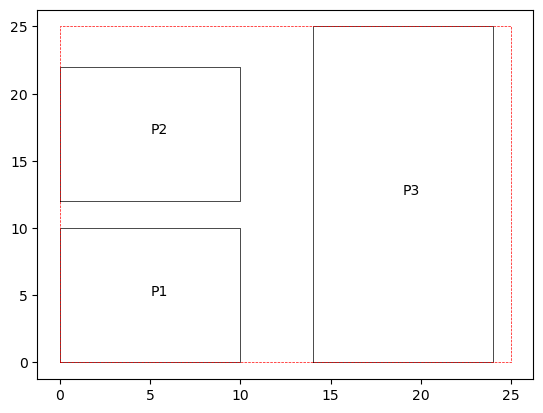

In [5]:
map.add_gdf(place_gdf, label='Place', alpha=0)
map.add_shape(county1)
map.plot()

### <a id='toc1_2_2_'></a>[Places 1 Parcel Data](#toc0_)

In [6]:
p1_1 = mPolygon(origin=(0, 0), size=(2,2))
p1_2 = mPolygon(origin=(0,2), size=(2,2))
p1_3 = mPolygon(origin=(0,4), size=(2,2))
p1_4 = mPolygon(origin=(0,6), size=(2,2))
p1_5 = mPolygon(origin=(0,8), size=(2,2))
p1_6 = mPolygon(origin=(2,0), size=(2,2))
p1_7 = mPolygon(origin=(2,2), size=(2,2))
p1_8 = mPolygon(origin=(2,4), size=(2,2))
p1_9 = mPolygon(origin=(2,6), size=(2,2))
p1_10 = mPolygon(origin=(2,8), size=(2,2))

p1_11 = mPolygon(origin=(6,0), size=(2,2))
p1_12 = mPolygon(origin=(6,2), size=(2,2))
p1_13 = mPolygon(origin=(6,4), size=(2,2))
p1_14 = mPolygon(origin=(6,6), size=(2,2))
p1_15 = mPolygon(origin=(6,8), size=(2,2))
p1_16 = mPolygon(origin=(8,0), size=(2,2))
p1_17 = mPolygon(origin=(8,2), size=(2,2))
p1_18 = mPolygon(origin=(8,4), size=(2,2))
p1_19 = mPolygon(origin=(8,6), size=(2,2))
p1_20 = mPolygon(origin=(8,8), size=(2,2))

p1_parcels = [p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p1_7, p1_8, p1_9, p1_10, p1_11, p1_12, p1_13, p1_14, p1_15, p1_16, p1_17, p1_18, p1_19, p1_20]

p1_parcel_data = {
    'OWNER': ['D', 'D', 'F', 'E', 'E', 'A', 'D', 'E', 'E', 'E', 'A', 'D', 'D', 'C', 'F', 'B', 'B', 'C', 'F', 'F']
}
p1_parcel_gdf = GeoDataFrame(p1_parcel_data, p1_parcels).build()

# add line to map
p1_line = mLine(coords=[(5, 0), (5, 10)], color='black')



In [7]:
map.add_gdf(p1_parcel_gdf, label='OWNER', alpha=0.2, color='blue')
map.add_shape(p1_line)

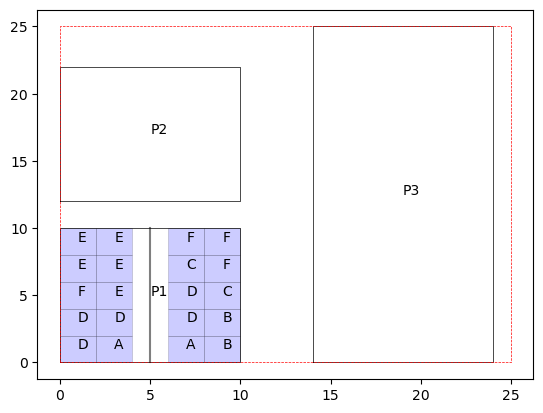

In [8]:
map.plot()

### <a id='toc1_2_3_'></a>[Places 2 Parcel Data](#toc0_)

In [9]:
p2_1 = mPolygon(origin=(0, 12), size=(2,2))
p2_2 = mPolygon(origin=(0,14), size=(2,2))
p2_3 = mPolygon(origin=(0,16), size=(2,2))
p2_4 = mPolygon(origin=(0,18), size=(2,2))
p2_5 = mPolygon(origin=(0,20), size=(2,2))
p2_6 = mPolygon(origin=(2,12), size=(2,2))
p2_7 = mPolygon(origin=(2,14), size=(2,2))
p2_8 = mPolygon(origin=(2,16), size=(2,2))
p2_9 = mPolygon(origin=(2,18), size=(2,2))
p2_10 = mPolygon(origin=(2,20), size=(2,2))

p2_11 = mPolygon(origin=(6,12), size=(2,2))
p2_12 = mPolygon(origin=(6,14), size=(2,2))
p2_13 = mPolygon(origin=(6,16), size=(2,2))
p2_14 = mPolygon(origin=(6,18), size=(2,2))
p2_15 = mPolygon(origin=(6,20), size=(2,2))
p2_16 = mPolygon(origin=(8,12), size=(2,2))
p2_17 = mPolygon(origin=(8,14), size=(2,2))
p2_18 = mPolygon(origin=(8,16), size=(2,2))
p2_19 = mPolygon(origin=(8,18), size=(2,2))
p2_20 = mPolygon(origin=(8,20), size=(2,2))


p2_parcels = [p2_1, p2_2, p2_3, p2_4, p2_5, p2_6, p2_7, p2_8, p2_9, p2_10, p2_11, p2_12, p2_13, p2_14, p2_15, p2_16, p2_17, p2_18, p2_19, p2_20]

p2_parcel_data = {
    'OWNER': ['E', 'C', 'C', 'C', 'E', 'E', 'B', 'F', 'A', 'D', 'F', 'F', 'C', 'C', 'C', 'F', 'G', 'H', 'I', 'J']
}
p2_parcel_gdf = GeoDataFrame(p2_parcel_data, p2_parcels).build()

# add line to map
p2_line = mLine(coords=[(5, 12), (5, 22)], color='black')


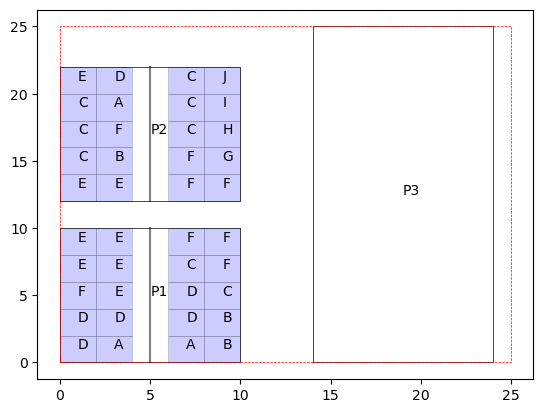

In [10]:
map.add_gdf(p2_parcel_gdf, label='OWNER', alpha=0.2, color='blue')
map.add_shape(p2_line)
map.plot()

### <a id='toc1_2_4_'></a>[Place 3 Parcel Data](#toc0_)

In [11]:
p3_p1 = mPolygon(origin=(14, 0), size=(2,2))
p3_p2 = mPolygon(origin=(14,2), size=(2,2))
#p3_p3 = mPolygon(origin=(14,9), size=(2,2))
#p3_p4 = mPolygon(origin=(14,11), size=(2,2))
p3_p5 = mPolygon(origin=(14,10), size=(2,2))
p3_p6 = mPolygon(origin=(16,10), size=(2,2))
p3_p7 = mPolygon(origin=(20,10), size=(2,2))
#p3_p8 = mPolygon(origin=(16,9), size=(2,2))
#p3_p9 = mPolygon(origin=(16,11), size=(2,2))
p3_p10 = mPolygon(origin=(14,20), size=(2,2))

#p3_11 = mPolygon(origin=(20,5), size=(2,2))
#p3_12 = mPolygon(origin=(20,7), size=(2,2))
p3_13 = mPolygon(origin=(20,0), size=(2,2))
p3_14 = mPolygon(origin=(22,4), size=(2,2))
#p3_15 = mPolygon(origin=(20,13), size=(2,2))
p3_16 = mPolygon(origin=(22,14), size=(2,2))
p3_17 = mPolygon(origin=(22,18), size=(2,2))
p3_18 = mPolygon(origin=(22,0), size=(2,2))
#p3_19 = mPolygon(origin=(22,11), size=(2,2))
#p3_20 = mPolygon(origin=(22,13), size=(2,2))

# add line to map
p3_line = mLine(coords=[(19, 0), (19, 25)], color='black')

p3_parcels = [p3_p1, p3_p2, p3_p5, p3_p6, p3_p7, p3_p10, p3_13, p3_14, p3_16, p3_17, p3_18]
p3_parcel_data = {
    'OWNER': ['A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D']
}
p3_parcel_gdf = GeoDataFrame(p3_parcel_data, p3_parcels).build()

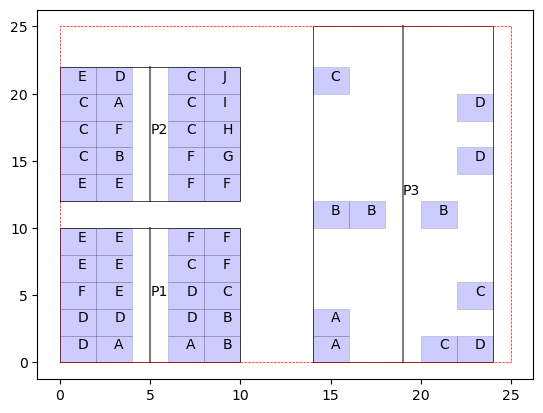

In [12]:
map.add_gdf(p3_parcel_gdf, label='OWNER', alpha=0.2, color='blue')
map.add_shape(p3_line)
map.plot()

In [13]:
parcels = pd.concat([p1_parcel_gdf, p2_parcel_gdf, p3_parcel_gdf], ignore_index=True)

display(parcels['OWNER'].value_counts())

OWNER
C    11
D     9
F     8
E     8
B     6
A     5
G     1
H     1
I     1
J     1
Name: count, dtype: int64

## <a id='toc1_3_'></a>[II. Clustering Workflow](#toc0_)
### <a id='toc1_3_1_'></a>[Functions](#toc0_)
#### <a id='toc1_3_1_1_'></a>[Step 1: Computing the Distance Matrix for each Region](#toc0_)
This step gives us the inital matrix with valid distance between each polygon in the region. This will then be used to calculate the density of the region.
#### <a id='toc1_3_1_2_'></a>[Step 2: Calculating the Density of the Region](#toc0_)
Density of each Region is calculated by dviding the number of parcels by the range of the distance matrix. Doing so, will help us calculate a dynamic and optimal n_neighbor parameter for the KNN algorithm. 
#### <a id='toc1_3_1_3_'></a>[Step 3: Calculating the Nearest Neighbors Sample Size](#toc0_)
The Number of Neighbors used in the KNN algorithm distaces how large the underlying clusters will be. The smaller the number of neighbors, the more more clusters will be localized. The larger the size, the looser the clusters will be. 

Ultimately, the number of neighbors will be used to calculate the optimal epsilon for the DBSCAN algorithm.
#### <a id='toc1_3_1_4_'></a>[Step 4: Calculating the Optimal Epsilon](#toc0_)
Computes the optimal distance for the DBSCAN algorithm:
    -Nearest Neighbors is used to fit the distance matrix and compute the distances for n_neighbors nearest neighbors.
    Dmatrix is reshaped to a 2d array to fit the Nearest Neighbors model.
    -The distances are sorted and smoothed using a uniform filter. This gives us a smooth curve of sorted distances which helps make the elbow more accurate.
    -The difference between the smoothed distances is computed to find the elbow point.
    -The optimal distance is computed as the distance at the elbow point. This distance is then rounded up and constrained to be between the min_urban_distance and max_distance.
    
    CONSTANTS:
    1. Min_urban_distance is the minimum distance between two likely neighbors. This could be the minimum distance across a street centerline to cluster neighboring parcels (i.e. 10 meters).
    2. Max_distance is the maximum distance between two likely neighbors. This could be set to 200 meters.

**What does the Optimal Epsilon represent?**
The optimal eplison is the optimal distance threshold for the particular region. The distance threshold means that same owner parcels must be within this distance to be considered a cluster. 

It was important to calculate the corrrect n_neighbors because this influences the distance. Without understanding the regions density, the eplison may be too large and therefore, the resulting super parcels will overlap neighboring parcels. Conversely, it could also be too small, and not capture all same-owner parcels.

#### <a id='toc1_3_1_5_'></a>[Step 5: Clustering the Data](#toc0_)
This step applies the DBSCAN algorithm to each Owner in each region. The same workflow is used as in Phase I, but with the optimal eplison.



In [14]:
def compute_regional_distance_matrix(df):
    """
    Computes the Distance Matrix for all polygons in each region (i.e. Place)
    Only the upper triangle of the matrix is computed as these are
    valid distances between polygons. The diagonal is removed as the
    distance between a polygon and itself is 0.
    """
    distance_matrix = df.geometry.apply(lambda g: df.distance(g)).values
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    distances = distances[distances > 0]

    return distances

def compute_density(dmatrix, num_parcels):
    """
    Density = Number of Parcels / Range of the Distance Matrix
    """
    density = len(sub_parcels) / np.ptp(dmatrix) 
    return density

def compute_nneighbors(density, min_nneighbors):
    """
    Scales the number of N Neighbors based on the density of the Region. 
    Takes the minimum of the computed value or the total number of parcels - 1
    """
    n_neighbors = max(1, int(min_nneighbors / density))
    return n_neighbors

def compute_optimal_distance(dmatrix, n_neighbors, min_urban_distance, max_distance):
    """
    Computes the optimal distance for the DBSCAN algorithm.
        -Nearest Neighbors is used to fit the distance matrix and compute the distances for n_neighbors nearest neighbors.
        Dmatrix is reshaped to a 2d array to fit the Nearest Neighbors model.
        -The distances are sorted and smoothed using a uniform filter. This gives us a smooth curve of sorted sitances which helps make the elbow more accurate.
        -The difference between the smoothed distances is computed to find the elbow point.
        -The optimal distance is computed as the distance at the elbow point. This distance is then rounded up and constrained to be between the min_urban_distance and max_distance.
        
        Min_urban_distance is the minimum distance between two liekly neighbors.
        Max_distance is the maximum distance between two likely neighbors. This will mostley be set to 200 meters.
    """
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(dmatrix.reshape(-1, 1))
    knn_distances, _ = knn.kneighbors(dmatrix.reshape(-1, 1))
    sorted_distances = np.sort(knn_distances[:, -1])
    smooth_dist = uniform_filter1d(sorted_distances, size=10)
    difference = np.diff(smooth_dist)
    elbow_index = np.argmax(difference) + 1

    # take distance from KNN elbow --> must be greater than min_urban_distance and less than max_distance
    knn_optimal_distance = smooth_dist[elbow_index]
    optimal_distance = min(max(ceil(knn_optimal_distance), min_urban_distance), max_distance)
    
    return optimal_distance, knn_optimal_distance

def polygon_distance(polygon1, polygon2):
    # Calculate the minimum distance between two polygons
    point1, point2 = nearest_points(polygon1, polygon2)
    return point1.distance(point2)

def compute_distance_matrix(polygons):
    # Create a distance matrix between all polygons
    num_polygons = len(polygons)
    distance_matrix = np.zeros((num_polygons, num_polygons))
    
    for i in range(num_polygons):
        for j in range(i + 1, num_polygons):
            distance_matrix[i, j] = polygon_distance(polygons[i], polygons[j])
            distance_matrix[j, i] = distance_matrix[i, j]  # Symmetry
    
    return distance_matrix


In [15]:
sample_size = 3 # clusters must have at least 3 parcels
min_urban_distance = 2 # min. distance between two likely neighbors
max_distance = 5 # max. distance between two likely neighbors


all_clustered_parcel_data = gpd.GeoDataFrame()
all_single_parcel_data = gpd.GeoDataFrame()
for place_id, place_data in place_gdf.iterrows():
    place_id += 1
    print(f"Processing place {place_id}")
    sub_parcels = parcels[parcels.within(place_data['geometry'])]
    
    distances = compute_regional_distance_matrix(sub_parcels)
   
    density = compute_density(distances, len(sub_parcels))

    min_nneighbors = max(0.1 * len(sub_parcels), 3) # 10% of the total number of parcels
    n_neighbors = compute_nneighbors(density, min_nneighbors)

    optimal_distance, knn_optimal_distance = compute_optimal_distance(distances, n_neighbors, min_urban_distance, max_distance)

    print(f'Density for Place {place_id}: {density}')
    print(f'Min N Neighbors for Place {place_id}: {min_nneighbors}')
    print(f'N Neighbors for Place {place_id}: {n_neighbors}')
    print(f'KNN distance for Place {place_id}: {knn_optimal_distance}')
    print(f"Optimal distance for Place {place_id}: {optimal_distance}")
    unique_owners = sub_parcels['OWNER'].unique()
    clustered_parcel_data = gpd.GeoDataFrame()
    single_parcel_data = gpd.GeoDataFrame()
    
    for owner in unique_owners:
        owner_parcels = sub_parcels[sub_parcels['OWNER'] == owner]
        #print(f"Owner {owner} has {len(owner_parcels)} parcels")
        polygons = owner_parcels['geometry'].to_list()
        distance_matrix = compute_distance_matrix(polygons)
        if distance_matrix.shape[0] < 3: # only two parcels
            continue

        dbscan = DBSCAN(eps=optimal_distance, min_samples=sample_size, metric='precomputed')
        clusters = dbscan.fit_predict(distance_matrix)

        owner_parcels['cluster'] = clusters # clustert ID
        owner_parcels['area'] = owner_parcels['geometry'].area
        counts = owner_parcels['cluster'].value_counts() # pd.series of cluster counts
        
        outliers = counts[counts.index == -1].index # outliers always identified as -1
        counts = counts[counts.index != -1] # drop outliers

        single_parcel_filter_ids = set(list(outliers)) # not apart of any cluster
            
        single_parcel_filter = owner_parcels[owner_parcels['cluster'].isin(single_parcel_filter_ids)]
        single_parcel_data = pd.concat([single_parcel_data, single_parcel_filter], ignore_index=True)
        
        cluster_filter = owner_parcels[~owner_parcels['cluster'].isin(single_parcel_filter_ids)]
        if len(cluster_filter) > 0:
            cluster_filter['pcount'] = cluster_filter['cluster'].map(counts) # add parcel count to filter dataframe
            cluster_filter['knn_dst'] = knn_optimal_distance
            cluster_filter['opt_dst'] = optimal_distance # dbscan distane is euivalent to the required buffer distance
            cluster_filter['place_id'] = place_id
            clustered_parcel_data = pd.concat([clustered_parcel_data, cluster_filter], ignore_index=True)

    # create cluster ID
    if len(clustered_parcel_data) != 0:
        clustered_parcel_data['cluster_ID'] = clustered_parcel_data['OWNER'] + '_' + str(place_id) + '_' + clustered_parcel_data['cluster'].astype(str)
        all_clustered_parcel_data = pd.concat([all_clustered_parcel_data, clustered_parcel_data], ignore_index=True)
    all_single_parcel_data = pd.concat([all_single_parcel_data, single_parcel_data], ignore_index=True)

        

    

    print('________________________________________________________')
    

Processing place 1
Density for Place 1: 3.0839062865407563
Min N Neighbors for Place 1: 3
N Neighbors for Place 1: 1
KNN distance for Place 1: 0.0
Optimal distance for Place 1: 2
________________________________________________________
Processing place 2
Density for Place 2: 3.0839062865407563
Min N Neighbors for Place 2: 3
N Neighbors for Place 2: 1
KNN distance for Place 2: 0.0
Optimal distance for Place 2: 2
________________________________________________________
Processing place 3
Density for Place 3: 0.6480627122784074
Min N Neighbors for Place 3: 3
N Neighbors for Place 3: 4
KNN distance for Place 3: 1.0844364454059576
Optimal distance for Place 3: 2
________________________________________________________



#### <a id='toc1_3_1_6_'></a>[Understanding The Variables](#toc0_)

- **Density**: The density of the region. This is the number of parcels divided by the range of the distance matrix. Higher the value, the more dense the region.
&nbsp;

- **Minimum Nearest Neighbors**: Either a constant (3 in this case) or 10% of the number of parcels in the region, whichever is greater.
&nbsp;

- **N Neighbors**: Min Neighbors divided by the density of region. Therefore, more neighbors are used to calculate the eplison in sparse regions and less neighbors are used in dense regions.
  - eg. High Density: min_neighbors = 3, density = 10, n_neighbors = 0.3
  - eg. Low Density: min_neighbors = 3, density = 1, n_neighbors = 3
&nbsp;

- **KNN Distance**: Calculated optimal distance from the KNN algorithm (i.e. the elbow)
&nbsp;

- **Optimal Distance**: The KNN distance greater than the minimum urban distance and less than the max distance.



In [16]:
parcel_dissolve = all_clustered_parcel_data.dissolve(by='cluster_ID').reset_index()
parcel_dissolve

,cluster_ID,geometry,OWNER,cluster,area,pcount,knn_dst,opt_dst,place_id
0,B_3_0,"MULTIPOLYGON (((14.00000 10.00000, 14.00000 12...",B,0,4.0,3,1.084436,2,3
1,C_2_0,"POLYGON ((2.00000 14.00000, 0.00000 14.00000, ...",C,0,4.0,3,0.000000,2,2
2,C_2_1,"POLYGON ((8.00000 16.00000, 6.00000 16.00000, ...",C,1,4.0,3,0.000000,2,2
3,D_1_0,"MULTIPOLYGON (((0.00000 0.00000, 0.00000 2.000...",D,0,4.0,5,0.000000,2,1
4,E_1_0,"POLYGON ((4.00000 4.00000, 2.00000 4.00000, 2....",E,0,4.0,5,0.000000,2,1
5,F_1_0,"POLYGON ((10.00000 6.00000, 8.00000 6.00000, 8...",F,0,4.0,3,0.000000,2,1
6,F_2_0,"MULTIPOLYGON (((6.00000 14.00000, 6.00000 16.0...",F,0,4.0,4,0.000000,2,2


In [17]:
parcel_dissolve['geometry'] = parcel_dissolve.apply(lambda x: x['geometry'].buffer(x['opt_dst']), axis=1)
parcel_dissolve['geometry'] = parcel_dissolve.apply(lambda x: x['geometry'].buffer(-x['opt_dst']), axis=1)
parcel_dissolve = parcel_dissolve.explode(index_parts=True)


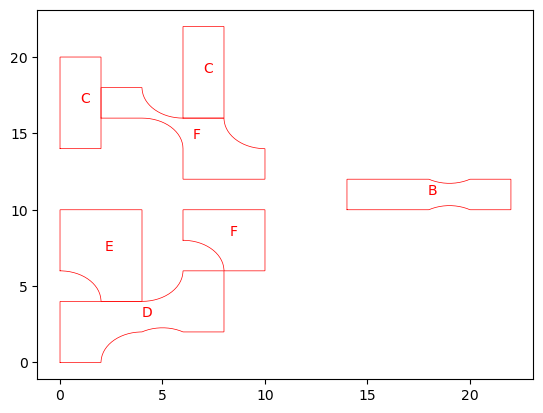

In [18]:
cluster_map = Map()
cluster_map.add_gdf(parcel_dissolve, alpha=0, edgecolor='red', label='OWNER', label_color='red')
cluster_map.plot()

In [19]:
map.add_gdf(parcel_dissolve, alpha=0, edgecolor='red', label='OWNER', label_color='red')

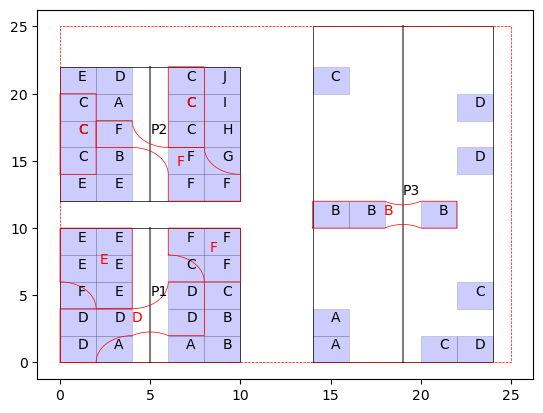

In [20]:
map.plot()

## <a id='toc1_4_'></a>[III. Results](#toc0_)
We see that each region has effectively captured same-owner parcels **within** each place boundary. **However**, is has NOT effectively captured same-owner parcels **between** place boundaries. 

If the distance between **P1** and **P2** is within the optimal distance, then same-owner **E** and **F** should have been a signle cluster. We see that two E-parcels in P2 were not clustered at all because they fell under the sample size of 3. Alternatively, we don't want the F-cluster in P1 to associate with the F-cluster in P3. These two regions are too far apart. 

This identifies a need to solve **Cross-Region Clustering**. This will be addressed below...

## <a id='toc1_5_'></a>[IV. Cross-Region Clustering](#toc0_)

### <a id='toc1_5_1_'></a>[Step 1: Identify Single Parcels within the Optimal Distance](#toc0_)


In [21]:
for single_id, single_data in all_single_parcel_data.iterrows():
    owner = single_data['OWNER']
    same_owner_n = all_clustered_parcel_data[(all_clustered_parcel_data['OWNER'] == owner)]
    if same_owner_n.empty:
        continue
    same_owner_n['cross_dist'] = same_owner_n['geometry'].apply(lambda x: polygon_distance(x, single_data['geometry']))
    same_owner_nclusters = same_owner_n.loc[same_owner_n['cross_dist'] <= 3]
    
    
    if same_owner_nclusters.empty:
        continue

    same_owner_ncluster = same_owner_nclusters.loc[same_owner_nclusters['cross_dist'].idxmin(), 'cluster_ID']
   
    add_single = all_single_parcel_data[all_single_parcel_data.index == single_id][['OWNER', 'geometry']]
    merge_n = all_clustered_parcel_data[all_clustered_parcel_data['cluster_ID'] == same_owner_ncluster]
    all_clustered_parcel_data = all_clustered_parcel_data[all_clustered_parcel_data['cluster_ID'] != same_owner_ncluster]

    same_owner_merge = pd.concat([same_owner_n, add_single], ignore_index=True).drop(columns=['cross_dist'])
    new_row_index = same_owner_merge.index[-1]
    source_row_index = same_owner_merge.index[0]
    for col in same_owner_merge.columns:
        if col != 'geometry':  # Skip the geometry field
            same_owner_merge.at[new_row_index, col] = same_owner_merge.at[source_row_index, col]

    all_clustered_parcel_data = pd.concat([all_clustered_parcel_data, same_owner_merge], ignore_index=True)

    
    
    
    

### <a id='toc1_5_2_'></a>[Step 2: Identify Same-Owner Clusters in different regions within the Optimal Distance](#toc0_)

In [22]:
def merge_cross_region_clusters(df, max_merge_distance=4):
    # Step 1: Identify owners spanning multiple regions
    owner_region_count = df.groupby(['OWNER', 'place_id']).size().unstack(fill_value=0)
    multi_region_owners = owner_region_count[owner_region_count.sum(axis=1) > 1].index

    # Step 2: For each multi-region owner, check distances between clusters
    for owner in multi_region_owners:
        
        owner_df = df[df['OWNER'] == owner]
        
        # Extract centroids for each cluster of the owner
        centroids = owner_df.geometry.centroid
        coords = list(zip(centroids.x, centroids.y))

        # Build a KDTree for fast distance lookup
        tree = cKDTree(coords)

        # Find pairs of clusters within the max_merge_distance
        pairs = tree.query_pairs(max_merge_distance)
        
        # Merge clusters if they are close enough
        for i, j in pairs:
            cluster_i = owner_df.iloc[i]['cluster_ID']
            cluster_j = owner_df.iloc[j]['cluster_ID']

            # Update cluster_ID to merge them
            df.loc[df['cluster_ID'] == cluster_j, 'cluster_ID'] = cluster_i

    return df


### <a id='toc1_5_3_'></a>[Step 3: Dissolve and Reverse Buffer](#toc0_)

In [23]:
all_clustered_parcel_data_merged = merge_cross_region_clusters(all_clustered_parcel_data)

In [24]:
parcel_dissolve_merge = all_clustered_parcel_data_merged.dissolve(by='cluster_ID').reset_index()
parcel_dissolve_merge

,cluster_ID,geometry,OWNER,cluster,area,pcount,knn_dst,opt_dst,place_id
0,B_3_0,"MULTIPOLYGON (((14.00000 10.00000, 14.00000 12...",B,0.0,4.0,3.0,1.084436,2.0,3.0
1,C_2_0,"POLYGON ((2.00000 14.00000, 0.00000 14.00000, ...",C,0.0,4.0,3.0,0.000000,2.0,2.0
2,C_2_1,"POLYGON ((8.00000 16.00000, 6.00000 16.00000, ...",C,1.0,4.0,3.0,0.000000,2.0,2.0
3,D_1_0,"MULTIPOLYGON (((0.00000 0.00000, 0.00000 2.000...",D,0.0,4.0,5.0,0.000000,2.0,1.0
4,E_1_0,"MULTIPOLYGON (((2.00000 4.00000, 2.00000 6.000...",E,0.0,4.0,5.0,0.000000,2.0,1.0
5,F_1_0,"MULTIPOLYGON (((8.00000 6.00000, 8.00000 8.000...",F,0.0,4.0,3.0,0.000000,2.0,1.0


In [25]:
parcel_dissolve_merge['geometry'] = parcel_dissolve_merge.apply(lambda x: x['geometry'].buffer(x['opt_dst']), axis=1)
parcel_dissolve_merge['geometry'] = parcel_dissolve_merge.apply(lambda x: x['geometry'].buffer(-x['opt_dst']), axis=1)

## <a id='toc1_6_'></a>[V. Cross-Region Clustering Results](#toc0_)

The results of this process have added **P2-E** and **P2-F** to **P1-E** and **P1-F** respectively. This is because the distance between **P1** and **P2** is within the optimal distance.

#### <a id='toc1_6_1_1_'></a>[Final Thoughts:](#toc0_)
- The process has effectively clustered same-owner parcels within each place boundary using a dynamically calcualted eplison based on the density of the region.
- The process has also effectively clustered same-owner parcels between place boundaries using a cross-region clustering process.


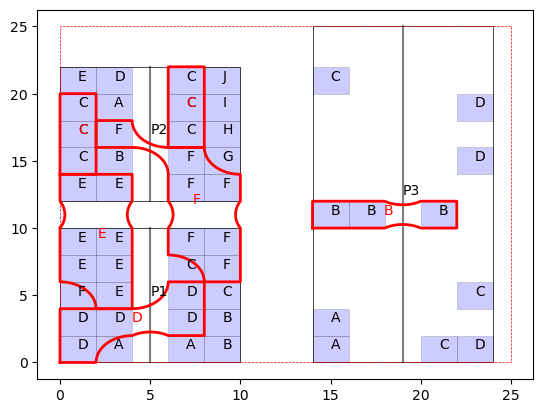

In [26]:
map.remove(parcel_dissolve)
map.add_gdf(parcel_dissolve_merge, alpha=0, edgecolor='red', label='OWNER', label_color='red', linewidth=2)
map.plot()